In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM , Dropout


In [8]:
from datetime import datetime

# Use today's date as the endpoint
ticker = "AAPL"
start_date = "2015-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')  # auto-updated

data = yf.download(ticker, start=start_date, end=end_date, progress=False)

if data.empty:
    print("⚠️ No data returned.")
else:
    print("✅ Data preview:")
    print(data.tail())


C:\Users\HP\AppData\Local\Temp\ipykernel_9212\2612903254.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)


✅ Data preview:
Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2025-06-26  201.000000  202.639999  199.460007  201.429993  50799100
2025-06-27  201.080002  203.220001  200.000000  201.889999  73188600
2025-06-30  205.169998  207.389999  199.259995  202.009995  91912800
2025-07-01  207.820007  210.190002  206.139999  206.669998  78788900
2025-07-02  212.440002  213.339996  208.139999  208.910004  67893400


In [11]:
close_prices = data['Close'].values.reshape(-1, 1)


# Normalize the data to range [0, 1] — this is critical for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

sequence_length = 60

X = []
y = []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i - sequence_length:i, 0])
    y.append(scaled_data[i, 0])

# Convert to NumPy arrays and reshape for LSTM
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [12]:
print("✅ Data prepared:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

✅ Data prepared:
X shape: (2580, 60, 1)
y shape: (2580,)


In [15]:
# Build the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))  # prevents overfitting

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1)) 

c:\Users\HP\ml-env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X, y, epochs=25, batch_size=32, validation_split=0.1)

Epoch 1/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0271 - val_loss: 0.0022
Epoch 2/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 3/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 4/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 5/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 6/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 7/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 8/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 9/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 10/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 11/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 12/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0

In [17]:
# Predict on the training set
predicted_prices = model.predict(X)

# Invert the scaling (back to original prices)
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1))
actual_prices = scaler.inverse_transform(y.reshape(-1, 1))


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


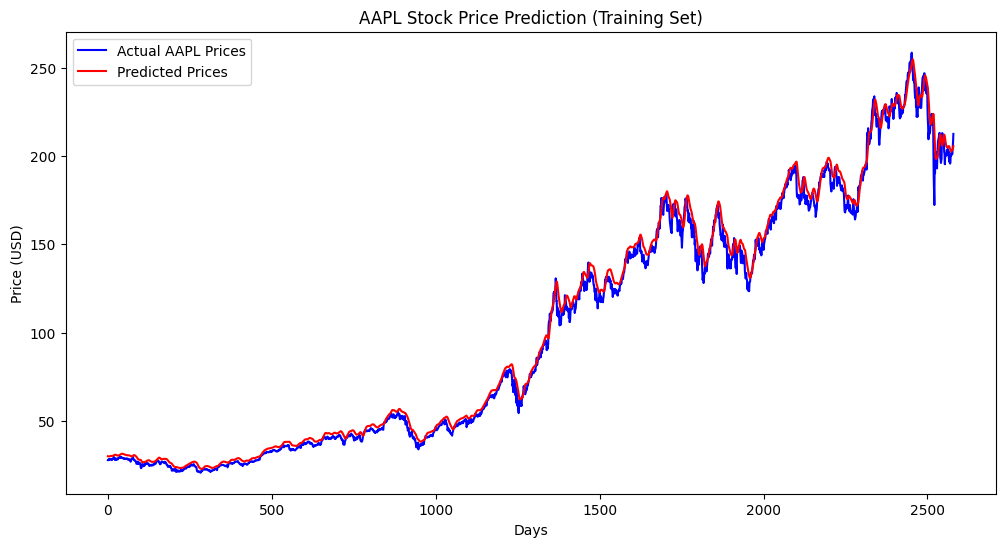

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, color='blue', label='Actual AAPL Prices')
plt.plot(predicted_prices, color='red', label='Predicted Prices')
plt.title('AAPL Stock Price Prediction (Training Set)')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [19]:
# Get the last 60 days (scaled) to simulate test input
last_60_days = scaled_data[-60:]

# Reshape to match LSTM input
X_test = np.reshape(last_60_days, (1, 60, 1))

# Predict next day's price
predicted_next_scaled = model.predict(X_test)

# Inverse scale to get predicted price in USD
predicted_next_price = scaler.inverse_transform(predicted_next_scaled)

print("📈 Predicted Next Closing Price:", predicted_next_price[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
📈 Predicted Next Closing Price: 207.09366


In [20]:
forecast_days = 7
input_sequence = list(scaled_data[-60:].flatten())  # start with last 60 days
predictions_scaled = []

for _ in range(forecast_days):
    # Prepare the current input shape
    current_input = np.array(input_sequence[-60:])  # last 60 values
    current_input = current_input.reshape((1, 60, 1))
    
    # Predict next day
    next_scaled = model.predict(current_input, verbose=0)
    
    # Save scaled prediction & append to input sequence
    predictions_scaled.append(next_scaled[0][0])
    input_sequence.append(next_scaled[0][0])

# Inverse scale the predictions to get real prices
predictions_scaled = np.array(predictions_scaled).reshape(-1, 1)
predictions_real = scaler.inverse_transform(predictions_scaled)

# Print results
print("📅 Next 7-Day Forecast:")
for i, price in enumerate(predictions_real.flatten(), 1):
    print(f"Day {i}: ${price:.2f}")


📅 Next 7-Day Forecast:
Day 1: $207.09
Day 2: $208.30
Day 3: $209.34
Day 4: $210.27
Day 5: $211.13
Day 6: $211.95
Day 7: $212.73


In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Step 1: Predict on training data (or test split if you have one)
predicted_scaled = model.predict(X)

# Step 2: Inverse transform both predicted and true values
predicted_prices = scaler.inverse_transform(predicted_scaled)
true_prices = scaler.inverse_transform(y.reshape(-1, 1))

# Step 3: Calculate metrics
mae = mean_absolute_error(true_prices, predicted_prices)
mse = mean_squared_error(true_prices, predicted_prices)
rmse = np.sqrt(mse)
r2 = r2_score(true_prices, predicted_prices)

# Step 4: Print results
print(f"📊 Mean Absolute Error (MAE): {mae:.2f}")
print(f"📉 Mean Squared Error (MSE): {mse:.2f}")
print(f"📈 Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"🔢 R² Score: {r2:.4f}")

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
📊 Mean Absolute Error (MAE): 3.70
📉 Mean Squared Error (MSE): 25.25
📈 Root Mean Squared Error (RMSE): 5.02
🔢 R² Score: 0.9947
